In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
%matplotlib inline

In [2]:
def simulate_assets(n, years, steps_per_year):
    x = [str(chr(x)) for x in np.arange(n)+ord("A")]
    t = np.linspace(0,years,years*steps_per_year)
    m = len(t)
    dz = pd.DataFrame(np.random.normal(0,np.sqrt(t[1]-t[0]),size=(m,n)), index = t, columns = x)
    dz.loc[0.0]=0.0
    vol = pd.DataFrame(index=t, columns=x, data = [np.random.uniform(size=n)/10.+0.1]*m)
    dt = pd.Series(dz.index).diff().fillna(0.0)
    s0 = np.random.exponential(size=3)+1.0
    return np.exp((((vol.shift()*dz)-0.5*(vol.shift()**2).mul(dt.values, axis=0)).fillna(0.0)).cumsum()).mul(s0, axis=1)

n=3
underlying_prices = simulate_assets(n,10,365)
t = underlying_prices.index

In [3]:
def bs_straddle(F,K,t,T, v):
    x = np.log(K/F)
    y = v*np.sqrt(T-t)
    d1=-x/y+y/2.
    d2=-x/y-y/2.
    return F*norm.cdf(d1)-K*norm.cdf(d2)+K*norm.cdf(-d2)-F*norm.cdf(-d1)

def bs_straddle_delta(F,K,t,T, v):
    x = np.log(K/F)
    y = v*np.sqrt(T-t)
    return 2*norm.cdf(-x/y+y/2)-1.0

In [6]:
def build_atm_straddle_vehicles(underlying_prices, target_maturity_days):
    vehicle = underlying_prices.stack().to_frame("K")
    vehicle["K"] = (vehicle["K"]*2.).round(1)/2. # assume strikes are listed every $0.05
    vehicle["T"] = ((pd.Series((vehicle.index.get_level_values(level=0)+target_maturity_days/365.))*2.).round(1)/2.).values # assume 20 expiries per year
    vehicle.index.rename(["t","und"], inplace=True)
    vehicle = vehicle.reset_index()

    # definition of the unique vehicles: all the (udnerlying, strike, expiry) combos that are traded at any time
    unique_vehicles = vehicle[["und","K","T"]].set_index(["und","K","T"], drop=False).drop_duplicates().reset_index(drop=True)

    # the the vehicle frame, defining what we trade on each day, is a mapping to the index of unique_vehicle
    lookup = unique_vehicles.reset_index().set_index(["und","K","T"])
    vehicle["i"] = lookup.loc[[tuple(x) for x in list(vehicle[["und","K","T"]].values)]].values
    vehicle = vehicle.set_index(["und","t"])["i"]
    
    return unique_vehicles, vehicle

vehicle_definition, traded_vehicles = build_atm_straddle_vehicles(underlying_prices, 30)

In [12]:
ivol = 0.15

option_prices = bs_straddle(
    underlying_prices[vehicle_definition["und"]].values,
    vehicle_definition["K"].values.reshape(1,-1),
    np.array(t).reshape(-1,1),
    vehicle_definition["T"].values.reshape(1,-1),
    ivol)
option_prices = pd.DataFrame(index = t, columns = vehicle_definition.index, data=option_prices)
option_prices = option_prices.sort_index(axis=0).sort_index(axis=1)

/home/sejones/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
/home/sejones/venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/sejones/venv/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


In [14]:
option_deltas = bs_straddle_delta(
    underlying_prices[vehicle_definition["und"]].values,
    vehicle_definition["K"].values.reshape(1,-1),
    np.array(t).reshape(-1,1),
    vehicle_definition["T"].values.reshape(1,-1),
    ivol)
option_deltas = pd.DataFrame(index = t, columns = vehicle_definition.index, data=option_deltas)
option_deltas = option_deltas.sort_index(axis=0).sort_index(axis=1)

/home/sejones/venv/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.
/home/sejones/venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


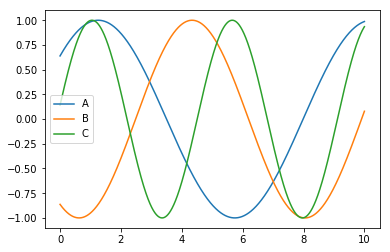

In [19]:
signal = np.sin(np.array(t).reshape(-1,1)*(np.random.exponential(size=(1,n)))+np.random.uniform(np.pi*1000,size=(1,n)))
signal = pd.DataFrame(index=t, columns = underlying_prices.columns, data=signal)
signal.plot()
None

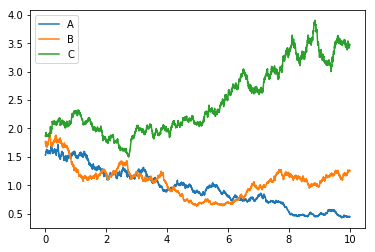

In [20]:
underlying_prices.plot()
None

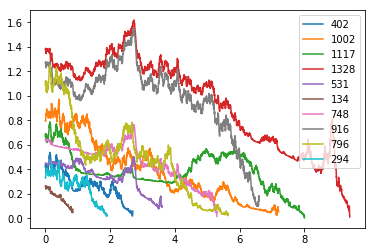

In [23]:
option_prices.sample(10, axis=1).plot()
None

Convert the signal to the trade frame, which specific option vehicles do we trade into on which days?

In [26]:
option_trades = signal.T.stack().T.to_frame("value")
option_trades["vehicle_id"] = traded_vehicles.loc[option_trades.index]
option_trades.index.rename(["underlying","date"], inplace=True)
option_trades.set_index("vehicle_id", append=True, inplace=True)
option_trades = option_trades.unstack(level="vehicle_id").fillna(0.0).groupby(level="date").sum()
option_trades.columns = option_trades.columns.droplevel()
option_trades = option_trades.sort_index(axis=0).sort_index(axis=1)

In [41]:
pd.set_option("display.max_rows", 6)
pd.set_option("display.max_columns", 15)
pd.set_option("display.float_format", "{:.2f}".format)
option_trades

vehicle_id,0,1,2,3,4,5,6,...,1417,1418,1419,1420,1421,1422,1423
date,,,,,,,,,,,,,,,
0.00,0.64,-0.86,0.14,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0.00,0.64,-0.86,0.14,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0.01,0.64,-0.87,0.15,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.99,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.99,0.07,0.93,0.00
10.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.99,0.08,0.00,0.93
10.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.99,0.08,0.93,0.00


What are our positions in each option? Simply the cumsum of the trades, dropping to zero at expiry.

In [29]:
assert (option_trades.index == option_prices.index).all()
assert (option_trades.columns == option_prices.columns).all()
option_positions = option_trades.cumsum().where(~option_prices.isnull(),0.0)

In [42]:
option_positions

vehicle_id,0,1,2,3,4,5,6,...,1417,1418,1419,1420,1421,1422,1423
date,,,,,,,,,,,,,,,
0.00,0.64,-0.86,0.14,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0.00,1.28,-1.73,0.28,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0.01,1.92,-2.59,0.43,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.99,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,3.65,10.14,1.84,0.99,0.07,0.93,0.00
10.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,3.65,10.14,1.84,1.97,0.15,0.93,0.93
10.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,3.65,10.14,1.84,2.96,0.23,1.87,0.93


In [37]:
delta_positions = (-option_positions * option_deltas).groupby(vehicle_definition["und"].loc[option_positions.columns], axis=1).sum()
delta_trades = delta_positions.diff()
delta_trades.iloc[0]=delta_positions.iloc[0]

Compute the full portfolio positions, trades and prices frames. These are the main building blocks of the sim PnL calculation.

In [39]:
positions = pd.concat((option_positions, delta_positions), axis=1)
trades = pd.concat((option_trades, delta_trades), axis=1)
prices = pd.concat((option_prices, underlying_prices), axis=1)
assert (trades.columns==prices.columns).all()
assert (positions.columns==prices.columns).all()

prices["Cash"] = 1.0 # value of a hypothetical MM acct, assuming r=0, easily generalised
cash_paid = -(trades * prices).sum(axis=1)
trades["Cash"] = cash_paid / prices["Cash"]
positions["Cash"] = trades["Cash"].cumsum()

/home/sejones/venv/lib/python3.6/site-packages/pandas/core/generic.py:7394: RuntimeWarning: '<' not supported between instances of 'int' and 'str', sort order is undefined for incomparable objects
  other.columns, how=join, level=level, return_indexers=True)


In [43]:
prices

,0,1,2,3,4,5,6,...,1421,1422,1423,A,B,C,Cash
0.00,0.06,0.07,0.07,0.07,0.08,0.08,0.10,...,0.71,1.69,1.74,1.53,1.76,1.87,1.00
0.00,0.06,0.07,0.07,0.09,0.08,0.08,0.11,...,0.69,1.70,1.74,1.54,1.73,1.86,1.00
0.01,0.06,0.06,0.07,0.08,0.08,0.08,0.11,...,0.69,1.70,1.75,1.53,1.75,1.86,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.99,nan,nan,nan,nan,nan,nan,nan,...,0.05,0.14,0.14,0.45,1.26,3.47,1.00
10.00,nan,nan,nan,nan,nan,nan,nan,...,0.05,0.14,0.13,0.44,1.25,3.48,1.00
10.00,nan,nan,nan,nan,nan,nan,nan,...,0.05,0.13,0.13,0.44,1.26,3.47,1.00


In [44]:
trades

,0,1,2,3,4,5,6,...,1421,1422,1423,A,B,C,Cash
date,,,,,,,,,,,,,,,
0.00,0.64,-0.86,0.14,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.10,0.13,-0.03,-0.32
0.00,0.64,-0.86,0.14,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.07,-0.37,0.00,0.54
0.01,0.64,-0.87,0.15,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.17,0.17,-0.01,-0.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.99,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.07,0.93,0.00,1.08,-0.10,-7.57,25.77
10.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.08,0.00,0.93,17.87,0.13,-3.47,3.96
10.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.08,0.93,0.00,-1.75,-0.29,1.25,-3.36


In [45]:
positions

,0,1,2,3,4,5,6,...,1421,1422,1423,A,B,C,Cash
date,,,,,,,,,,,,,,,
0.00,0.64,-0.86,0.14,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.10,0.13,-0.03,-0.32
0.00,1.28,-1.73,0.28,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.17,-0.25,-0.02,0.22
0.01,1.92,-2.59,0.43,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.34,-0.08,-0.03,-0.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.99,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.07,0.93,0.00,12.03,-0.20,-5.54,52.62
10.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.15,0.93,0.93,29.90,-0.07,-9.01,56.58
10.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.23,1.87,0.93,28.15,-0.36,-7.76,53.22


In [47]:
pnl = (positions.shift()*prices.diff()).fillna(0.0)
pnl

,0,1,2,3,4,5,6,...,1421,1422,1423,A,B,C,Cash
date,,,,,,,,,,,,,,,
0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,...,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00
0.01,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,...,0.00,0.00,0.00,-0.00,-0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.99,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,-0.00,-0.00,-0.00,0.00,-0.00,0.05,0.00
10.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,-0.00,-0.00,-0.00,-0.12,0.00,-0.06,0.00
10.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,-0.00,-0.00,-0.00,0.09,-0.00,0.08,0.00


In [48]:
# portfolio is self-financing
assert (trades * prices).sum(axis=1).abs().max() < 1e-8

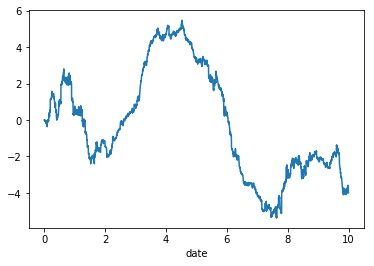

In [50]:
pnl.sum(axis=1).cumsum().plot()
None

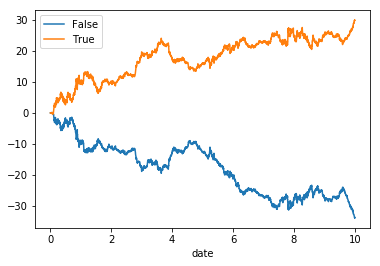

In [63]:
is_hedge = list(np.in1d(pnl.columns, underlying_prices.columns))
pnl.T.groupby(is_hedge, sort=True).sum().T.cumsum().plot()

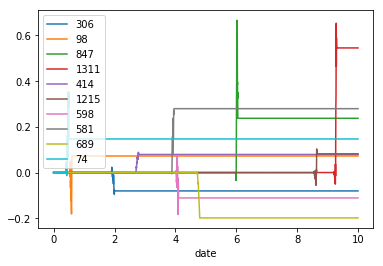

In [67]:
pnl.sample(10, axis=1).cumsum().plot()

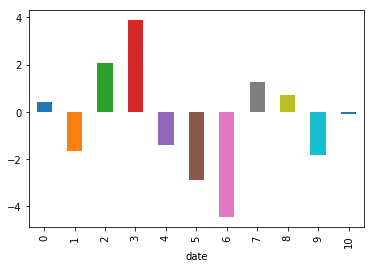

In [72]:
pnl.groupby(pnl.index.astype(int)).sum().sum(axis=1).plot(kind="bar")